In [22]:
using Pkg
Pkg.activate("../../../juliaenv")
Pkg.status()

  Activating project at `~/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/uni/juliaenv`


Status `~/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/uni/juliaenv/Project.toml`
  [13f3f980] CairoMakie v0.11.9
  [0c46a032] DifferentialEquations v7.13.0
  [7a1cc6ca] FFTW v1.8.0
  [7073ff75] IJulia v1.24.2
  [2774e3e8] NLsolve v4.5.1
  [f27b6e38] Polynomials v4.0.7
  [92933f4c] ProgressMeter v1.10.0
  [295af30f] Revise v3.5.14


Simulate the planets in the solar system! A numerical solution of the N-body problem

$$H(p,q) = \frac 12 \sum_i \frac{1}{m_i} p_i^Tp_i - G \sum_i \sum_{j<i} \frac{m_im_j}{\lvert q_i-q_j \rvert} $$

Using Hamilton's equations we can write this as

In [28]:
using CairoMakie
using Base64

#set_theme!(theme_dark())
set_theme!(theme_light())

In [24]:
### Planetary data for Q2
# Mass (m), initial position (x) and initial velocity (v)
# for all relevant objects

# Mass in units of solar masses (i.e. sun has mass 1)
# Position in astronomical units (1AU ~ 1.49e8 km)
# Time in days

# Sun and inner planets combined
m0 = 1.00000597682
x0 = [0.0 0.0 0.0]
v0 = [0.0 0.0 0.0]

# Jupiter
m1 = 0.000954786104043
x1 = [-3.5023653 -3.8169847 -1.5507963]
v1 = [0.00565429 -0.00412490 -0.00190589]

# Saturn
m2 = 0.000285583733151
x2 = [9.0755314 -3.0458353 -1.6483708]
v2 = [0.00168318 0.00483525 0.00192462]

# Uranus
m3 = 0.0000437273164546
x3 = [8.3101420 -16.2901086 -7.2521278]
v3 = [0.00354178 0.00137102 0.00055029]

# Neptune
m4 = 0.0000517759138449
x4 = [11.4707666 -25.7294829 -10.8169456]
v4 = [0.00288930 0.00114527 0.00039677]

# Pluto
m5 = 1.0 / (1.3e8)
x5 = [-15.5387357 -25.2225594 -3.1902382]
v5 = [0.00276725 -0.00170702 -0.00136504]

### Gravitational constant (in the same units)
G = 2.95912208286e-4

# q = x = postion
# p = v = velocity (momentum)

m = [m0, m1, m2, m3, m4, m5]
q0 = vcat(x0, x1, x2, x3, x4, x5)  # 6x3
p0 = vcat(v0, v1, v2, v3, v4, v5) .* m  # convert from velocity to momentum

6×3 Matrix{Float64}:
 0.0           0.0           0.0
 5.39864e-6   -3.9384e-6    -1.81972e-6
 4.80689e-7    1.38087e-6    5.4964e-7
 1.54873e-7    5.9951e-8     2.40627e-8
 1.49596e-7    5.92974e-8    2.05431e-8
 2.12865e-11  -1.31309e-11  -1.05003e-11

In [35]:
# equation parameters
Δt = 10
tmax = 2000000
T = range(0, tmax, step=Δt)
tnum = length(T)

200001

In [17]:
# Hamilton equations

function Hp(p)
    # Return dH/dp
    return p ./ m
end

function norm(x)
    return sqrt(sum([xx^2 for xx in x]))
end

function Hq(q)
    # Return dH/dq
    hq = zeros((6,3))
    for k in 1:6
        kth = zeros(3)
        for i in vcat(1:k-1,k+1:6)
            #println("k=$k, i=$i")
            kth += (q[i,:]-q[k,:]) .* (m[i] / norm(q[i,:]-q[k,:])^3)
        end
        kth *= G * m[k]
        hq[k,:] = kth
    end
    return -hq
end

# System solvers

function euler(Δt=10)
    # Explicit Euler
    tnum = length(1:Δt:tmax)
    P = zeros(tnum, 6, 3)
    Q = zeros(tnum, 6, 3)
    P[1,:,:] = p0
    Q[1,:,:] = q0
    
    for t in 2:tnum
        p = P[t-1,:,:]
        q = Q[t-1,:,:]
        P[t,:,:] = p - Δt*Hq(q)
        Q[t,:,:] = q + Δt*Hp(p)
    end
    return P, Q
end

function stormer(Δt=10.0)
    # Stormer-Verlet
    println(Δt)
    tnum = length(1:Δt:tmax)
    P = zeros(tnum, 6, 3)
    Q = zeros(tnum, 6, 3)
    P[1,:,:] = p0
    Q[1,:,:] = q0
    
    for t in 2:tnum
        p = P[t-1,:,:]
        q = Q[t-1,:,:]
    
        q12 = q + Δt/2 * Hp(p)
        #p12 = p - Δt/2 * Hq(q12)
        P[t,:,:] = p - Δt * Hq(q12)
        Q[t,:,:] = q12 + Δt/2 * Hp(P[t,:,:])
    end 
    return P, Q
end

function H(p,q)
    # System Hamiltonian
    K = 1/2 * sum([p[i,j]^2/m[i] for j in 1:3, i in 1:6]) 
    V = 0
    for i in 1:6
        for j in i+1:6
            V -= G*m[i]*m[j]/norm(q[i,:]-q[j,:])
        end
    end
    return K+V
end

H (generic function with 1 method)

In [36]:
# Solve the equation
P, Q = stormer()

#P, Q = euler()

10.0


([0.0 5.398637520229294e-6 … 1.4959614787206956e-7 2.1286538461538464e-11; -5.352327368666089e-8 5.4607503566528195e-6 … 1.4953198405848446e-7 2.1299921196780697e-11; … ; 1.220229942327539e-5 -7.337737912820884e-6 … -4.097751958034663e-8 2.4426972522153962e-11; 1.220985786233707e-5 -7.3404103428918915e-6 … -4.114452458791378e-8 2.4429824459055185e-11;;; 0.0 -3.938397200566971e-6 … 5.9297400849148624e-8 -1.3130923076923078e-11; -7.181326305135359e-8 -3.86979119698702e-6 … 5.9441097898224353e-8 -1.3109178052320067e-11; … ; -3.952329949400332e-6 4.925576902659614e-7 … 1.4624923766219502e-7 -4.202236070798738e-12; -3.858475521265126e-6 3.918512758889078e-7 … 1.4620830342473405e-7 -4.1795413434201706e-12;;; 0.0 -1.8197172878345132e-6 … 2.0543129336240974e-8 -1.0500307692307693e-11; -2.9589400952938922e-8 -1.7918230933850772e-6 … 2.0603540438054592e-8 -1.0497554846314351e-11; … ; -1.9751958557687176e-6 3.7749009571717713e-7 … 6.088886190758894e-8 -8.70223209739205e-12; -1.9357111558713126e-6

In [19]:
# Hamiltonian over time
# energy = [H(P[i,:,:], Q[i,:,:]) for i in 1:tnum]

# fig, ax, lns = lines(energy)

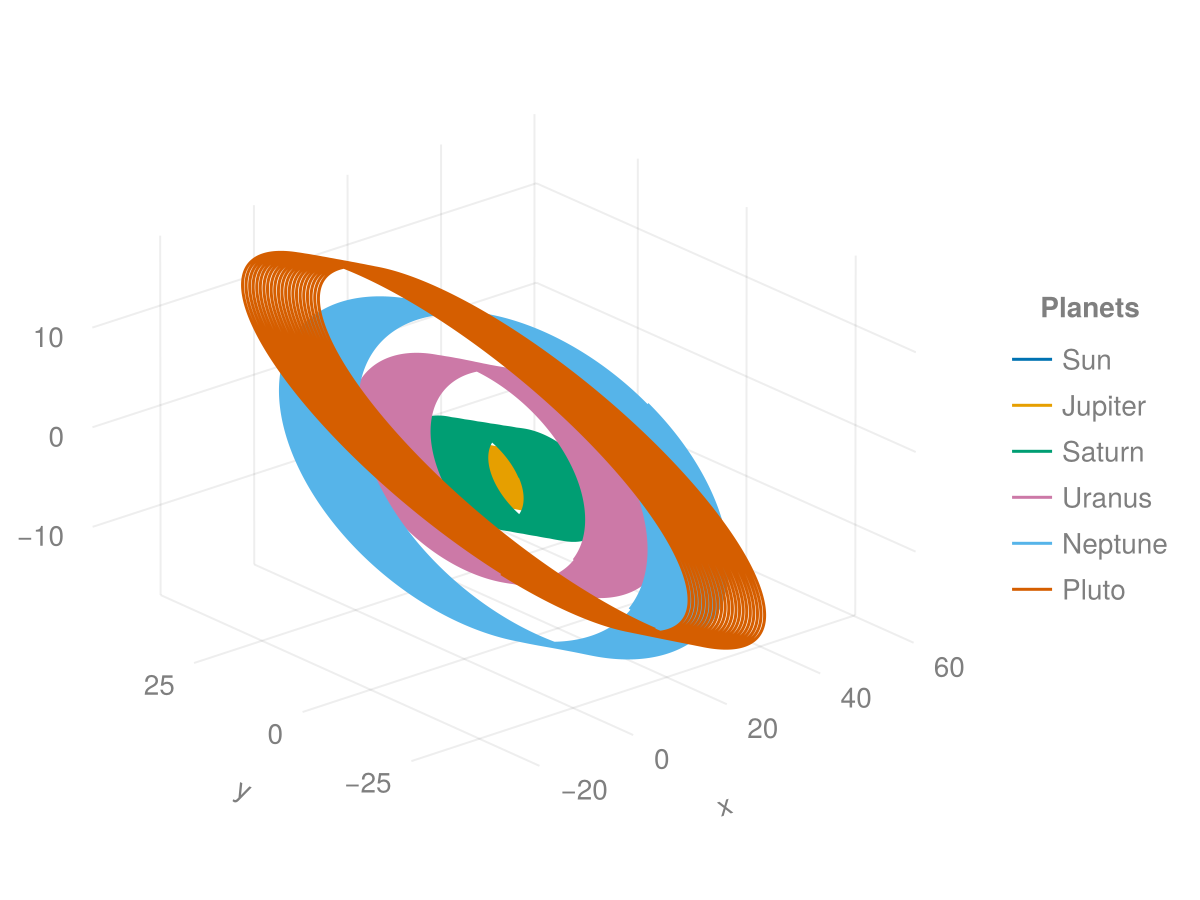

In [37]:
# Plot the planet paths
planets = ["Sun", "Jupiter", "Saturn", "Uranus", "Neptune", "Pluto"]
fig = Figure()
ax = Axis3(fig[1,1])

for k in 1:6
    lines!(ax, (Q[:,k,i] for i in 1:3)..., label=planets[k])
end

#Makie.wong_colors()[k], 

Legend(fig[1,2], ax, "Planets")
fig

In [21]:
# Animate the solar system!

tskip = 50
taillength = 1500

t = Observable(taillength)

fig = Figure()
ax = Axis3(fig[1,1], title = @lift("t= $(round($t*Δt/365, digits=2)) years"),)

planets = ["Sun", "Jupiter", "Saturn", "Uranus", "Neptune", "Pluto"]

tail = @lift($t-taillength+1:$t)

for k in 1:6
    scatter!(ax, @lift(Q[$t,k,1]), @lift(Q[$t,k,2]), @lift(Q[$t,k,3]), label=planets[k])
    lines!(ax, @lift(Q[$tail,k,1]), @lift(Q[$tail,k,2]), @lift(Q[$tail,k,3]))
end

Legend(fig[1,2], ax, "Planets")

limits!(ax,
    minimum(Q[:,:,1]), maximum(Q[:,:,1]),
    minimum(Q[:,:,2]), maximum(Q[:,:,2]),
    minimum(Q[:,:,3]), maximum(Q[:,:,3])
)

fname = "planets.mp4"
record(fig, fname, taillength:tskip:tnum; framerate = 20) do tstep
    t[] = tstep
    ax.azimuth[] = 1.7pi + 0.3 * sin(2pi * tstep / (50*120)) 
end

println("Rendering HTML")
display("text/html", string("""<video autoplay loop width=600><source src="data:video/x-m4v;base64,""",
                            base64encode(open(read, fname)),"""" type="video/mp4"></video>"""))
println("Saved as '$(fname)'")

Rendering HTML


<source src="data:video/x-m4v;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQASiVltZGF0AAACoQYF//+d3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xvb2thaGVhZD01MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIwLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAGcAZYiEADP//vdonwKbJ78qA5JXFJdtPgf+rZ3B8j+kDAAY/yAAAAMAAAMAAGHTqWDvE6H7v/EAAAMAAATsAAlboAuZz+jXDcgRQsYXEvbeS9SMISAlWynQUeyHcADa7/KHEnPdM7qJ42AgrvTuqi4MFaD5C4g9hn7MjhrurXarf9Yx2m/IzQKgyIY9cxQJpjmRHbsEgXxlCtSVcI9p+U0Tr+XPOjRiRNae/NMXjpMCw0ivHiMGZLQ5ihr2mGbtKT7LyHinBRQ+gzCBsIwn9UhH+F8cTHgcTwk2otGr3ML7HJnC9Ap9TNNoDDOR1y+/uOcf3RjhUkjaxCnGOlTJUCKob3UjBfKyz0DD2iTLZ8V8VJdiS85mD0oWa4rE4gqLrNKEFwW94CyR7H0xvwyPf077DHRueWseupjtMmNroeEijsFtlCcOjZvTDRtLpu8hbmdvM0vqYz29PFJWVGZR9oy1emKhG9j6Y4+kUUn0N+oVzir/YSwyPjir28bvIbrrqp5l8A5N70yJzxwT8WHuNZ1zKUOO+TZHWl2F6gRY5x1sNZGdkP5ngrkz1nNy/qUSzzcXkbt3F1FSFHB1AXgjWWYtBV5J67XxUnfWHdGFrLPvbdW2h8jt/85J5NHehN1egXxn4yNk0Mm3EnLmfSHGzqiOTW0y2kcQSn/kaWrhYoLnmZPW5y7vFEMA4HlJN+dGfTkGCBzaq4py+9bB9dWbq8LeHiQIeciI4cpkjWTMkAY+QDGuV8mkk4IZPwPllhRp7xJbMwRXZKjdjUmkAFH6GDVNVy5+dWfIxVUpKjSKbyCFk7VklHP1bZsFXG41ox0l4/9muvUZUwUroqAakmgwMb7k74sJHB6k3PrKliRqUgrVVkZcXgpuQ5Dri1Ap44wbLFfMKOMO8lEOPA3p6O92vHs39LsUrONksJV77I3PY32bR6qwrc+dEJtL8i/aSwe9TZNWRzNyK9xbmMkQDq/oQ4nZ/WHWODDwQ0yHO5xpW2r3cxo4xOD68po4inhSH3wIhb/arqKT9F8TQIy2/E8ipwxw9b5vq2+KCw+Jzj1wmALslMs/KfLcDsstx0neTCWjGy6JlAqhPlHNfTU/m6Zt5vgqAHD+EaQALzWbyAk82eIQ9wTKHUBaD7Uav/V55fP6hB2e94eXxBXlb/5YPL/DVy66P0o9KYmaCSIsRlyVp9RE2A0rj+yVzzv0YOuz7HnMpWVj5MP/c/JNsbkuCkxWIg9HF76bW8dZFKQQmK5xf+ETnM810W0tqUifnKYdhaer+FwvVEgIbDDOuI918Dv/yRhGMzBSmcib3xHOPtKeA+0hCJuEd9HXkOPz7TGT9PSTc3NYrpETX/IeDcJ5EAaDUl2hirohJXZhP6EMw+yibVJ7ZiIw0EZseiEYgDRBXi4v/8sk6l62AoNZxXk7jz16uV0FcpMMj4aTVNym8SYfjdSEQ2d5eHnSEv9JU6yzWsGpYEqo2BIgAESN4OM04SfgoPcNOGhCz2DnAAes4zGmHNUQ1jRhz5AnFQoNmLab0u5hFuTw4LOlTmTPkKDMzbxBEosphFBNPQ4ynVND0lVhUCPOyQTwegY1hDVUNW8JIL3oQoiEtT2pqvFJaqwRtQayf9aCZzvc+I9YmaeYyitqw3hcdr2CNXaQHEVElBZm6TzL1qNtFHfcuZI2yyqqp8VLLxgIRzYONPQ+ZvSqVsrLDAFdEWILn0suaB4yMaGvdjVxipFT/DH/BrKNcEatRSaBgTsZnyRGI22yRW43M/3GQg/tkBiSQg5VBqCG5opj0N8bKeV8cIzV8Y3eNarL+ndh7LriUfWf2I172W6zHwzVkKD6SsncqafgbkaA5+9edveG5zQcnV6mWw31v4Mu+W6snTgpj+0BC5R5TSQyOU+k+ksMlSEuArfluNStUwpRDPg/H0iVV3rPpD9CS6YvpgsG0jaRqDK70wHk2gEJiW4JE6G/0Fzoq4yiZhpjQBuZ1UAQ/ZqjZ2BRqUdlxRdb9+0noEEnl4QquiRU7FAcbK1gtHNV5EglZSYzb0XlBwJkE/BBqNkJ0dcd22EaWmOqJ01Rj6+Rp57d/97X7zC+BXpN9E0p7Y7RzsFb9vAud1B2Y/I7HoW9ZMzLsJ83xNJHTPQxZaukp2vYPQLzdio9zczWzUUVYwb0HiUTQXU7/xtO/u1v3HCikNRAWI6qVJZYF8A6lDaT10dqsZSpwl8wKYG1WWDdFKN7rww+W83AUTcGuckE/xlO1UXRkHvRWzxacWIh7yk6fDgnFvMr/9bhV16xaqZ7YQAF8RIjOBL0vjV6nt4RnJuiH2MPWrzmAmjzD8+N9rKkNo2ruNLkm+SMY738FYCcuqKAbFj8/KD9vZhE+hg4xWPzj+Ltc3aIvI/0SAEhWwFtNPy6HGToIMvrF7cP5oNhA8BQIIi9FAfWFAHSKd0GDZe+BbA8vKOjv6bJmululwcv5HdeZW2dqbHUrDQEJ2Q2G1jVVKdDQNnJpy21ljK8UGV1DUx1LWLLWfL22uVgu/ITAm0JIng6TbamUCyRdPhtHSFgOeH/I3IX7wI2ACbN6qhi7lsRhyihZTCEo7P7nSQI/+SmytXgwJvJmRD/4Nik1ACdKa3QJyqxF74R9dAzi5dKToT1bWBMLj/8R7LtegUxjKDYge+PZjQ8IhOXIyknySl8JU1nmFc3T7icPwgNxi3MvBzb/94hCiBxyPPUljfH/ScsEKIsSQTkT9uGbwgTwLqBEv2vQZW1sF1P+OWiPVwU8ZQHivL/F+2RT2KX8ywExJ4D1xYlhkpbqdLx+4TqFYOv/TSNWV/vvWf70XcW7ZOdOtSvCeXIQ4r2yummdLyyLXvygZQnjDJCVQSAp5ZCavu+M4el3BOFgMp2CxZqXlYhQdqMr6/DBeGi5noJ4+yaqAAOZZ6QkFBCkgLM/JfO5HaTv6ZkySSLakM4vl8hladShPmyIXBl2+SZ2AN+R+Kz8qu3IqRp+IRm4L89OxynD6Iv+FP

Saved as 'planets.mp4'


In [41]:
# compute errors

tmax = 200000

Δt = 100
tnum = length(1:Δt:tmax)
P100, Q100 = stormer()

Δt = 10
tnum = length(1:Δt:tmax)
P10, Q10 = stormer()

Δt = 1
tnum = length(1:Δt:tmax)
P1, Q1 = stormer()

#Δt = 0.1
#tnum = length(1:Δt:tmax)
#P01, Q01 = stormer()

([0.0 5.398637520229294e-6 … 1.4959614787206956e-7 2.1286538461538464e-11; -5.396082776837294e-9 5.404891522138332e-6 … 1.4958973881636687e-7 2.1287877895084432e-11; … ; -9.176812054483277e-7 6.860237330748404e-6 … -1.2387073021833964e-7 1.2540335355392848e-11; -9.157685704755464e-7 6.8574840043799536e-6 … -1.2388199540772567e-7 1.2539126615988527e-11;;; 0.0 -3.938397200566971e-6 … 5.9297400849148624e-8 -1.3130923076923078e-11; -7.1470427387399094e-9 -3.9315728065324e-6 … 5.93117732838691e-8 -1.3128749088405362e-11; … ; -3.2173941277876075e-6 2.1128186898044745e-6 … 9.790523708249024e-8 1.6214564832319468e-11; -3.2269573396507853e-6 2.1220914052701815e-6 … 9.789302088424073e-8 1.6215019060231354e-11;;; 0.0 -1.8197172878345132e-6 … 2.0543129336240974e-8 -1.0500307692307693e-11; -2.9431303170910235e-9 -1.8169444288868367e-6 … 2.0549171381277984e-8 -1.050003291774543e-11; … ; -1.3933087650631603e-6 7.397014059031515e-7 … 4.315541773072584e-8 1.295178403101792e-12; -1.3974291313280508e-6 7

In [94]:
P1, Q1 = stormer(1)
q1 = sum(Q1[end,:,:])

X = [50.0, 100.0, 200, 500, 1000]
Qs = [stormer(i)[2] for i in X]
error = [sum(Q[end,:,:])-q1 for q in Qs]

1
50.0
100.0
200.0
500.0
1000.0


5-element Vector{Float64}:
 -0.1438835676825505
 -0.1438835676825505
 -0.1438835676825505
 -0.1438835676825505
 -0.1438835676825505

In [95]:
stormer(1000)

1000


([0.0 5.398637520229294e-6 … 1.4959614787206956e-7 2.1286538461538464e-11; 1.52947155465063e-7 6.118159689110995e-6 … 1.4240140361575723e-7 2.2491925486198438e-11; … ; 1.0406400788723332e-5 -5.508019474252845e-6 … -8.896748219775161e-8 1.5496572294561995e-11; 1.0716222283410368e-5 -5.471224418024189e-6 … -1.0284194250733632e-7 1.430949416285201e-11;;; 0.0 -3.938397200566971e-6 … 5.9297400849148624e-8 -1.3130923076923078e-11; -6.353943579139148e-6 2.3221969800419536e-6 … 7.331124374808156e-8 -1.0911828538710232e-11; … ; -6.298118002119113e-6 3.4062018625747007e-6 … 1.260893714352658e-7 1.4656013927803644e-11; -1.372499671608003e-6 -2.1859240389983324e-6 … 1.1661488295279709e-7 1.530678894615016e-11;;; 0.0 -1.8197172878345132e-6 … 2.0543129336240974e-8 -1.0500307692307693e-11; -2.742096708387533e-6 8.463189263470215e-7 … 2.645795439881726e-8 -1.017105002488078e-11; … ; -2.9389789258439585e-6 1.5876827414443099e-6 … 5.3822311264028164e-8 -8.274579362245295e-14; -8.372696992994345e-7 -8.04

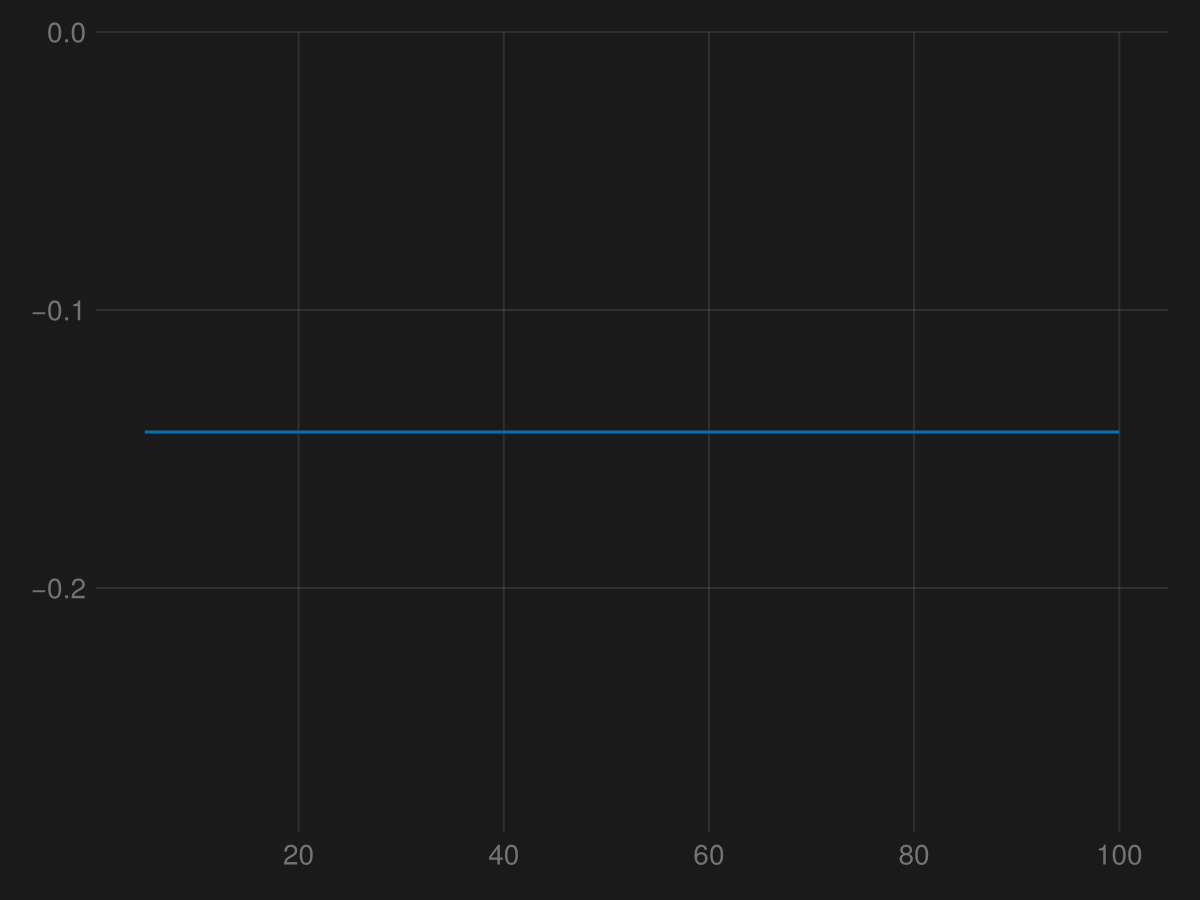

In [93]:
# Plot
fig = Figure()
ax = Axis(fig[1,1])

lns = lines!(ax, X, error)
fig

In [59]:
q = Q10[end,:,:]-Q1[end,:,:]
sum(q)

-0.14388356768255717